In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# webscraping
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

In [17]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

In [18]:
website_us = "https://waterservices.usgs.gov/nwis/site/?format=rdb&sites="

In [19]:
end = "&siteOutput=expanded&siteStatus=all"

In [20]:
ids = np.loadtxt(f'{data_folder}\\station_ids.txt').astype(np.int64)
len(ids)

109

In [21]:
output_path_gdf = f"{gis_folder}\\discharge_stations.gpk"
if os.path.exists(output_path_gdf):
    gdf_station=gpd.read_file(output_path_gdf,driver="GPKG",crs="EPSG:4326")  
else:
    df_lst = []
    for i in ids:
        site = website_us + f'0{i}' + end
        page = urlopen(site)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        splitted = html[2297:].split("\n")
        header = splitted[0].split('\t')
        data = splitted[2].split('\t')
        df_lst.append(pd.DataFrame(data=[data],columns=header))
    df_stations = pd.concat(df_lst)

    df_stations.reset_index(drop=True,inplace=True)

    gdf_station = gpd.GeoDataFrame(data=df_stations, 
                     geometry=gpd.points_from_xy(df_stations.dec_long_va,df_stations.dec_lat_va,crs="EPSG:4326"))

    gdf_station.to_file(output_path_gdf, driver="GPKG")

In [22]:
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   

# fixing crs
for layer in [outline,main_rivers,all_rivers]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [23]:
outline.geometry.iloc[0].bounds

(-75.56701999240448,
 40.733333333333356,
 -72.93334791395397,
 44.150000000000006)

In [24]:
def plot_map(gdf_station, ax):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
        
    ax.set_xlim(-75.8,-72.8)
    ax.set_ylim(40.5, 44.5)
    # remove lat/lon markers
    ax.set_xticks([])
    ax.set_yticks([])

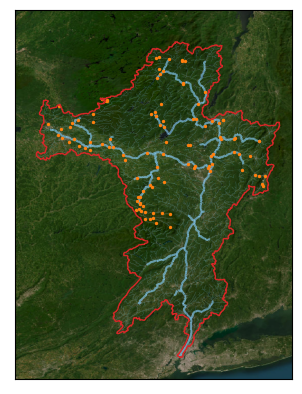

In [25]:
fig, ax = plt.subplots(1)
plot_map(gdf_station, ax)

# link to loading discharge data:

import the station which have discharge data and filter these

In [26]:
ids_with_Q = np.loadtxt(f'{data_folder}\\station_ids_with_Q.txt').astype(np.int64)

In [27]:
gdf_station_with_Q_out = gdf_station[gdf_station.apply(lambda x: True if int(x.site_no[1:]) in ids_with_Q else False,axis=1)]

In [28]:
gdf_station_with_Q_out.to_file(f"{gis_folder}\\discharge_stations_with_Q.gpk", driver="GPKG")

In [29]:
gdf_station_with_Q_out

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,0131199050,FISHING BROOK (COUNTY LINE FLOW OUTLET) NR NEW...,ST,435838.6,0741613.5,43.97738889,-74.2704167,N,1,...,,Y,,,,,,,GAZETTEER,POINT (-74.27042 43.97739)
1,USGS,01311992,ARBUTUS POND OUTLET NEAR NEWCOMB NY,ST,435856,0741408,43.9822222,-74.2355556,M,S,...,,NNNNNNNN,,,,,,,MCHALE-ALTM,POINT (-74.23556 43.98222)
2,USGS,01312000,HUDSON RIVER NEAR NEWCOMB NY,ST,435757.7,0740753.0,43.96602778,-74.13138889,N,1,...,,NNNNNNNN,,,,,,,,POINT (-74.13139 43.96603)
3,USGS,01313500,CEDAR R BELOW CHAIN LAKES NR INDIAN LAKE NY,ST,435123.7,0741420.6,43.8565833,-74.2390556,N,1,...,,NNNNNNNN,,,,,,,,POINT (-74.23906 43.85658)
4,USGS,01314000,"HUDSON R AT GOOLEY, NEAR INDIAN LAKE NY",ST,435002.0,0741140.8,43.83388889,-74.1946667,N,1,...,,NNNNNNNN,,,,,,,,POINT (-74.19467 43.83389)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,USGS,01356190,LISHA KILL NORTHWEST OF NISKAYUNA NY,ST,424701,0735124,42.7836111,-73.8566667,M,S,...,,NNNNNNNN,,,,,,,NAWQA,POINT (-73.85667 42.78361)
105,USGS,01357499,MOHAWK RIVER DIVERSION AT CRESCENT DAM NY,ST,424810,0734211,42.8028554,-73.7026186,M,S,...,,NNNNNNNN,,,,,,,,POINT (-73.70262 42.80286)
106,USGS,01357500,MOHAWK RIVER AT COHOES NY,ST,424707.4,0734228.0,42.78538889,-73.70777778,N,1,...,,NNNNNNNN,,,,,,,,POINT (-73.70778 42.78539)
107,USGS,01358000,HUDSON RIVER AT GREEN ISLAND NY,ST,424508,0734120,42.7522222,-73.68888889,M,S,...,,NNNNNNNN,,,,,,,,POINT (-73.68889 42.75222)
